### Load libraries

In [1]:
import copy
import pathlib
import sys

import git.repo
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from tqdm.auto import tqdm

GIT_ROOT = pathlib.Path(
    str(git.repo.Repo(".", search_parent_directories=True).working_tree_dir)
)
sys.path.append(str(GIT_ROOT))

from src.pretrain import linear_probe
from src.utils import runs_to_df

### Load data

In [2]:
CIFAR_CLS_NAMES = (
    "plane",
    "car",  # "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
)

In [3]:
def get_cifar_ds(normalize: bool = True) -> linear_probe.Dataset:
    d = np.load(
        "/home/gridsan/groups/ccg/data/scaling/clip-embeddings/cifar10_clip.npz"
    )

    xs_train: np.ndarray = d["xs_train"]
    ys_train: np.ndarray = d["ys_train"]
    xs_test: np.ndarray = d["xs_test"]
    ys_test: np.ndarray = d["ys_test"]

    if normalize:
        ss = StandardScaler()
        ss.fit(xs_train)
        xs_train = ss.transform(xs_train)  # type: ignore
        xs_test = ss.transform(xs_test)  # type: ignore

    return linear_probe.Dataset(xs_train, ys_train, xs_test, ys_test, name="cifar")


DS = get_cifar_ds(normalize=True)
print(DS.xs_train.shape, DS.ys_train.shape, DS.xs_test.shape, DS.ys_test.shape)

(50000, 768) (50000,) (10000, 768) (10000,)


### Compute Gaussian proxy of data

In [4]:
DS_G = copy.deepcopy(DS)
DS_G.name = "gaussian"
for c in range(10):
    mask_train = DS_G.ys_train == c
    mask_test = DS_G.ys_test == c

    xs = np.concatenate([DS_G.xs_train[mask_train], DS_G.xs_test[mask_test]])

    # Fit a gaussian to xs
    mu = np.mean(xs, axis=0)
    sigma = np.cov(xs, rowvar=False)

    # Sample from the gaussian
    n_train = np.sum(mask_train)
    n_test = np.sum(mask_test)
    xs_train_g = np.random.multivariate_normal(mu, sigma, size=n_train)
    xs_test_g = np.random.multivariate_normal(mu, sigma, size=n_test)

    # Replace the original data with the gaussian samples
    DS_G.xs_train[mask_train] = xs_train_g
    DS_G.xs_test[mask_test] = xs_test_g

In [5]:
NOISE_LEVEL = 8e-3
DS_G_noisy = copy.deepcopy(DS)
DS_G_noisy.name = "noisy"

mask_train = np.random.uniform(size=DS_G.ys_train.shape) < NOISE_LEVEL
mask_test = np.random.uniform(size=DS_G.ys_test.shape) < NOISE_LEVEL

DS_G_noisy.ys_train[mask_train] = np.random.randint(0, 10, size=np.sum(mask_train))
DS_G_noisy.ys_test[mask_test] = np.random.randint(0, 10, size=np.sum(mask_test))

### Collect scaling data

In [6]:
DATA = []

In [7]:
for n_train in tqdm(list(range(1, 16)) + [32, 64, 100, 500, 1000]):
    for C in [0.01]:
        for seed in range(1):
            for n_classes in [10]:
                for ds in (DS, DS_G, DS_G_noisy):
                    DATA.append(
                        linear_probe.run_experiment(
                            ds=ds,
                            n_train=n_train,
                            n_classes=n_classes,
                            C=C,
                            max_iter=10000,
                            seed=seed,
                        )
                        | {"name": ds.name}
                    )


  0%|          | 0/20 [00:00<?, ?it/s]

/home/gridsan/twang/code/scaling/src/pretrain/linear_probe.py:36: RuntimeWarning: divide by zero encountered in log
  return -np.log(aprobs[np.arange(len(aprobs)), labs_test]).mean()
/home/gridsan/twang/code/scaling/src/pretrain/linear_probe.py:36: RuntimeWarning: divide by zero encountered in log
  return -np.log(aprobs[np.arange(len(aprobs)), labs_test]).mean()


In [8]:
for n_train in tqdm([5000, 10000, 50000]):
    for C in [0.01]:
        for seed in range(1):
            for n_classes in [10]:
                for ds in (DS, DS_G, DS_G_noisy):
                    DATA.append(
                        linear_probe.run_experiment(
                            ds=ds,
                            n_train=n_train,
                            n_classes=n_classes,
                            C=C,
                            max_iter=10000,
                            seed=seed,
                        )
                        | {"name": ds.name}
                    )

  0%|          | 0/3 [00:00<?, ?it/s]

# Analyze data

In [9]:
df = pd.DataFrame(DATA)
df["err"] = 1 - df.acc
df.head()

,n_classes,C,max_iter,seed,n_train,acc,xent,name,err
0,10,0.01,10000,0,1,0.1000,inf,cifar,0.9000
1,10,0.01,10000,0,1,0.1000,inf,gaussian,0.9000
2,10,0.01,10000,0,1,0.1007,inf,noisy,0.8993
3,10,0.01,10000,0,2,0.1437,inf,cifar,0.8563
4,10,0.01,10000,0,2,0.1218,inf,gaussian,0.8782


In [10]:
# df.to_csv("gmm-v2.csv", index=False)

### CLIP scaling

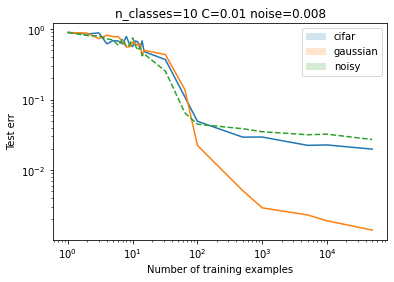

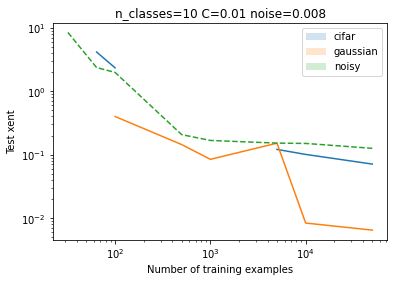

In [11]:
for metric in ["err", "xent"]:
    for name in df.name.unique():
        gb = df.query(f"name == '{name}'").groupby("n_train")[metric]
        lo = gb.min()
        mid = gb.median()
        hi = gb.max()

        plt.plot(
            mid.index,
            mid,
            **({"linestyle": "--"} if name == "noisy" else {}),
        )
        plt.fill_between(
            mid.index,
            lo,
            hi,
            alpha=0.2,
            label=name,
        )

    plt.title(f"n_classes=10 C=0.01 noise={NOISE_LEVEL}")
    plt.legend()
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("Number of training examples")
    plt.ylabel(f"Test {metric}")
    plt.show()